## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"   # disable GPU
os.environ['WANDB_NOTEBOOK_NAME'] = 'immortar_notebook'
os.environ['WANDB_API_KEY'] = '41acbb043aff8df0314092f00990f3f3ddf86440'
os.environ['WANDB_MODE'] = 'online'

In [3]:
# !pip install tensorflow_hub tensorflow_addons tensorflow_datasets

In [4]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_addons as tfa
import tensorflow.keras.backend as K

import tensorflow_datasets as tfds
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

# import wandb
# wandb.login()
# wandb.init(sync_tensorboard=True, project='immortar_hypersearch')

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

import time

from PIL import Image
import requests
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

import os
from pathlib import Path
import pandas as pd

import cv2
import multiprocessing
import shutil
import random
from PIL import ImageFile

from functools import partial

### Config

In [32]:
major_version = 6
minor_version = 2

mortar_type = "india"

np.random.seed(43)
root_dir = Path('../..')
data_dir = root_dir / "data"
csv =  root_dir / "data" /  (mortar_type + '.csv')
model_folder = data_dir / "models"

ALPHA = 0.4

# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)

## Load dataset

In [6]:
def explore_dataset(ds):
    for x in tfds.as_numpy(ds.take(2)):
        if isinstance(x, dict):
            print(x['image'].shape, x['label'])
        else:
            print(x[0].shape, x[1].shape, x[1].flatten()[:5])

#### Load our data

In [7]:
# train_dir = data_dir / 'dummy_train'
train_dir = data_dir / 'train'

In [8]:
IMG_STRUCTURE = '*/*'   # where are the images stored compared to the train_dir

CLASS_NAMES = [path.name for path in train_dir.glob('*')]  # from plotting helper functions above
NUM_CLASSES = len(CLASS_NAMES)
num_examples = len(list(train_dir.glob(f'{IMG_STRUCTURE}.png'))) + len(list(train_dir.glob(f'{IMG_STRUCTURE}.jpg')))

def get_label(file_path, multiplier=1):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
#     value = tf.strings.split(parts[-1], '_')[0]

#     return tf.where(parts[-2] == CLASS_NAMES)[0][0]   # classification
    return tf.strings.to_number(parts[-2])             # regression
#     return tf.strings.to_number(value) * multiplier             # regression

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    return img  

def process_path(file_path, multiplier=1):
    label = get_label(file_path, multiplier=multiplier)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    features = {'image': img, 'label': label}
    return features

def get_raw_dataset(dir_path, multiplier=1):
    list_ds = tf.data.Dataset.list_files(str(dir_path/IMG_STRUCTURE))
    process_path_mult = partial(process_path, multiplier=multiplier)
    ds = list_ds.map(process_path_mult, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return ds

explore_dataset(get_raw_dataset(train_dir))

(512, 512, 3) 14.0
(512, 512, 3) 25.0


In [9]:
ds_train = get_raw_dataset(data_dir / 'train')
ds_val = get_raw_dataset(data_dir / 'valid')
ds_test = get_raw_dataset(data_dir / 'test')

DATASET_NUM_TRAIN_EXAMPLES = len(ds_train)
DATASET_NUM_TRAIN_EXAMPLES

19115

In [10]:
explore_dataset(ds_train)

(512, 512, 3) 24.0
(512, 512, 3) -13.0


In [11]:
explore_dataset(ds_test)

(512, 512, 3) -26.0
(512, 512, 3) 8.0


### Create BiT model

In [12]:
#@title Set dataset-dependent hyperparameters

#@markdown Here we set dataset-dependent hyperparameters. For example, our dataset of flowers has 3670 images of varying size (a few hundred x a few hundred pixels), so the image size is larger than 96x96 and the dataset size is <20k examples. However, for speed reasons (since this is a tutorial and we are training on a single GPU), we will select the `<96x96 px` option and train on lower resolution images. As we will see, we can still attain strong results.

#@markdown **Algorithm details: how are the hyperparameters dataset-dependent?** 

#@markdown It's quite intuitive - we resize images to a smaller fixed size if they are smaller than 96 x 96px and to a larger fixed size otherwise. The number of steps we fine-tune for is larger for larger datasets. 

IMAGE_SIZE = "> 96 x 96 px" #@param ["=<96x96 px","> 96 x 96 px"]
DATASET_SIZE = "20k-500k examples" #@param ["<20k examples", "20k-500k examples", ">500k examples"]

if IMAGE_SIZE == "=<96x96 px":
    RESIZE_TO = 160
    CROP_TO = 128
else:
    RESIZE_TO = 512
    CROP_TO = 480

if DATASET_SIZE == "<20k examples":
    INIT_SCHEDULE_LENGTH = 500
    SCHEDULE_BOUNDARIES = [200, 300, 400]
elif DATASET_SIZE == "20k-500k examples":
    INIT_SCHEDULE_LENGTH = 10000
    SCHEDULE_BOUNDARIES = [3000, 6000, 9000]
else:
    INIT_SCHEDULE_LENGTH = 20000
    SCHEDULE_BOUNDARIES = [6000, 12000, 18000]

In [13]:
DUMMY_MODE = True
if DUMMY_MODE:
    RESIZE_TO = 96
    CROP_TO = 64
    INIT_SCHEDULE_LENGTH = 50
    SCHEDULE_BOUNDARIES = [20, 30, 40]
    
RESIZE_TO = 256
CROP_TO = 256
INIT_SCHEDULE_LENGTH = 500
SCHEDULE_BOUNDARIES = [200, 300, 400]

In [14]:
print(f'Selected:\nRESIZE_TO={RESIZE_TO}'
      f'\nCROP_TO={CROP_TO}'
      f'\nINIT_SCHEDULE_LENGTH={INIT_SCHEDULE_LENGTH}'
      f'\nSCHEDULE_BOUNDARIES={SCHEDULE_BOUNDARIES}')

Selected:
RESIZE_TO=256
CROP_TO=256
INIT_SCHEDULE_LENGTH=500
SCHEDULE_BOUNDARIES=[200, 300, 400]


In [15]:
# Load model into KerasLayer
model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
# model_url = "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1"
bit_model = hub.KerasLayer(model_url)

In [16]:
# Add new head to the BiT model

def get_basic_module(x):
    x = tf.keras.layers.Conv2D(64, 3, (2, 2), activation='relu')(x)
#     x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, 3, (2, 2), activation='relu')(x)
#     x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(32, 3, (2, 2), activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    return x

def build_basic_model(module):
    input_ = tf.keras.layers.Input((CROP_TO, CROP_TO, 3))
    x = module(input_)   # Outputs feature vectors [None, 2048]

    activation = 'relu'
    kernel_initializer = 'lecun_uniform'
    output_initializer = 'lecun_uniform'

#     for i in range(1):
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64,
                              activation=activation, 
                              kernel_initializer=kernel_initializer)(x)
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.Dropout(0.2)(x)
#     x = tf.keras.layers.Dense(32,
#                               activation=activation, 
#                               kernel_initializer=kernel_initializer)(x)
    x = tf.keras.layers.Dense(1, kernel_initializer=output_initializer)(x)
    
    model_ = tf.keras.Model(input_, x)
    
    return model_

# model = build_basic_model(bit_model)
model = build_basic_model(get_basic_module)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 127, 127, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 31, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 32)          18464     
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 32)         

In [17]:
import tensorflow_probability as tfp
# Preprocessing helper functions

# Create data pipelines for training and testing:
BATCH_SIZE = 32
SCHEDULE_LENGTH = INIT_SCHEDULE_LENGTH * 512 / BATCH_SIZE

STEPS_PER_EPOCH = len(ds_val) // BATCH_SIZE

RESIZE_TO_X = RESIZE_TO_Y = RESIZE_TO
CROP_TO_X = CROP_TO_Y = CROP_TO

def mixup(features):
    new_order = tf.random.shuffle(tf.range(BATCH_SIZE))
    dist = tfp.distributions.Beta(ALPHA, ALPHA)
    ratio = dist.sample(BATCH_SIZE)
    
    features['image'] = ratio[:,None,None,None] * features['image'] + (1 - ratio[:,None,None,None]) * tf.gather(features['image'], new_order)
    features['label'] = ratio * features['label'] + (1 - ratio) * tf.gather(features['label'], new_order)
    
    return features

def cast_to_tuple(features):
    return (features['image'], features['label'])

def preprocess_train(features):
    # Apply random crops and horizontal flips for all tasks 
    # except those for which cropping or flipping destroys the label semantics
    # (e.g. predict orientation of an object)
#     features['image'] = tf.image.random_flip_left_right(features['image'])
    features['image'] = tf.image.resize(features['image'], [RESIZE_TO_X, RESIZE_TO_Y])
#     features['image'] = tf.image.random_crop(features['image'], [CROP_TO_X, CROP_TO_Y, 3])
    features['image'] = tf.cast(features['image'], tf.float32) / 255.0
    return features

def preprocess_test(features):
    features['image'] = tf.image.resize(features['image'], [RESIZE_TO_X, RESIZE_TO_Y])
#     features['image'] = tf.image.resize_with_crop_or_pad(features['image'], CROP_TO_X, CROP_TO_Y)
    features['image'] = tf.cast(features['image'], tf.float32) / 255.0
    return features

pipeline_train = (ds_train
#                   .shuffle(10000)
                  .repeat(int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH) + 1 + 50)  # repeat dataset_size / num_steps
                  .map(preprocess_train, num_parallel_calls=1)
                  .batch(BATCH_SIZE)
#                   .map(mixup, num_parallel_calls=8)
                  .map(cast_to_tuple)  # for keras model.fit
                  .prefetch(2))

pipeline_val = (ds_val.map(preprocess_test, num_parallel_calls=8)
                  .batch(BATCH_SIZE)
                  .map(cast_to_tuple)  # for keras model.fit
#                   .cache()
                  .prefetch(2))

pipeline_test = (ds_test.map(preprocess_test, num_parallel_calls=8)
                  .batch(BATCH_SIZE)
                  .map(cast_to_tuple)  # for keras model.fit
#                   .cache()
                  .prefetch(2))

In [18]:
explore_dataset(pipeline_train)

(32, 256, 256, 3) (32,) [ -3. -24.   0.  -6.  -7.]
(32, 256, 256, 3) (32,) [  9.   9. -23.  -5.   8.]


In [19]:
# explore_dataset(pipeline_val)

In [20]:
def weighted_MAE(y_true, y_pred):
    return K.relu(K.abs(y_true - y_pred) - K.abs(y_pred) * 0.3 - 1) * 0.9 + 0.1 * K.abs(y_true - y_pred)

In [21]:
# Define optimiser and loss

lr = 0.004 * BATCH_SIZE / 512 

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [22]:
optimizer = tfa.optimizers.RectifiedAdam(learning_rate=0.008,
                                        beta_1=0.95,
                                        beta_2=0.99,
                                        epsilon=1e-6)
optimizer = tfa.optimizers.Lookahead(optimizer, sync_period=6, slow_step_size=0.5)
loss_fn = tf.keras.losses.MSE
# loss_fn = weighted_MAE

### Caveats
- The `fit` leaks memory => to run another `fit`, the kernel should be restarted.

### Train and eval
#### Caution
Each time the pipeline_test is accessed, the items are returned in an arbitrary order.


Error bars in graph are 1 std, which is 68% confidence for 1 value, 95% for 4 values, 99.7% for 9 values...

In [23]:
def get_stats(df):
    ser = pd.Series()
    for col in df.select_dtypes(include=np.number).columns:
        ser[f'{col}_mean'] = df[col].mean()
        ser[f'{col}_std'] = df[col].std()
    return ser

def eval_model(model_, ds_, div_factor=1):
    results = np.concatenate([np.stack([model_.predict(x, batch_size=64, workers=4).flatten(), y], axis=1) for x, y in tfds.as_numpy(ds_)])
#     print(weighted_MAE(*tf.transpose(results)))
    df = pd.DataFrame(results, columns=['pred', 'true']).groupby('true').apply(get_stats)
    df.pred_mean *= div_factor
    min_error = 1
    final_opt_div_factor = 1
    for opt_div_factor in np.arange(1 / 3, 1 * 3, 1 / 30):
        error = np.average(np.asarray(np.abs(df.index - df.pred_mean * opt_div_factor) > 1 + 0.3 * np.abs(df.index), np.float32))
        if error < min_error:
            final_opt_div_factor = opt_div_factor
            min_error = error
    plt.errorbar(df.index, df.pred_mean, df.pred_std * 2, linestyle='None', marker='^')
    results_1 = \
        f"MAE {np.average(np.abs(df.index - df.pred_mean))}\n" + \
        f"MSE {np.sqrt(np.average(np.abs(df.index - df.pred_mean) ** 2))}\n" + \
        f"outside {np.average(np.asarray(np.abs(df.index - df.pred_mean) > 1 + 0.3 * np.abs(df.index), np.float32))}"
    
    df.pred_mean *= final_opt_div_factor
    plt.errorbar(df.index, df.pred_mean, df.pred_std * 2, linestyle='None', marker='^', color='green')
    results_2 = \
        f"opt factor {final_opt_div_factor}, with div_factor {div_factor}\n" + \
        f"opt MAE {np.average(np.abs(df.index - df.pred_mean))}\n" + \
        f"opt MSE {np.sqrt(np.average(np.abs(df.index - df.pred_mean) ** 2))}\n" + \
        f"opt outside {np.average(np.asarray(np.abs(df.index - df.pred_mean) > 1 + 0.3 * np.abs(df.index), np.float32))}"
    plt.plot([-20, 0, 20], [-27, -1, 13], color='red')
    plt.plot([-20, 0, 20], [-13, 1, 27], color='red')
    plt.ylim(min(df.pred_mean) - 2, max(df.pred_mean) + 2)
    plt.show()
    return results_1 + "\n\n" + results_2
    
# print(eval_model(model, pipeline_test))

In [35]:
callbacks = [
#     tf.keras.callbacks.TensorBoard(profile_batch=0,),
    tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True),
]

model.compile(optimizer=optimizer,
              loss=loss_fn,
#               metrics=['mae', 'mse', weighted_MAE])
              metrics=['mae', 'mse',])
epochs = 100 #int(SCHEDULE_LENGTH / STEPS_PER_EPOCH)
# Fine-tune model
EVAL_FREQ = 4

Train for total of 100 epochs:
Epoch 1/4
135/135 - 5s - loss: 12.2809 - mae: 2.6657 - mse: 12.2809 - val_loss: 11.1446 - val_mae: 2.4909 - val_mse: 11.1446
Epoch 2/4
135/135 - 5s - loss: 11.2947 - mae: 2.5818 - mse: 11.2947 - val_loss: 13.6706 - val_mae: 2.8247 - val_mse: 13.6706
Epoch 3/4
135/135 - 5s - loss: 12.6721 - mae: 2.7204 - mse: 12.6721 - val_loss: 7.9676 - val_mae: 2.0987 - val_mse: 7.9676
Epoch 4/4
135/135 - 5s - loss: 12.0967 - mae: 2.6425 - mse: 12.0967 - val_loss: 14.7872 - val_mae: 3.0367 - val_mse: 14.7872
Results on validation:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


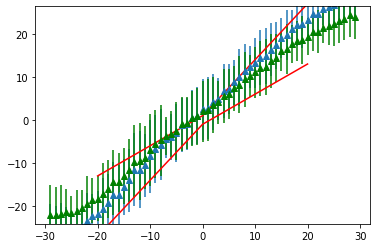

Epoch 5/8
135/135 - 5s - loss: 10.7542 - mae: 2.5449 - mse: 10.7542 - val_loss: 9.2495 - val_mae: 2.2261 - val_mse: 9.2495
Epoch 6/8
135/135 - 5s - loss: 10.0476 - mae: 2.4262 - mse: 10.0476 - val_loss: 29.7864 - val_mae: 4.2362 - val_mse: 29.7864
Epoch 7/8
135/135 - 5s - loss: 12.1676 - mae: 2.6080 - mse: 12.1676 - val_loss: 19.5086 - val_mae: 3.3124 - val_mse: 19.5086
Epoch 8/8


KeyboardInterrupt: 

In [36]:
print(f'Train for total of {epochs} epochs:')
for i in range(0, epochs, EVAL_FREQ):
    history = model.fit(
        pipeline_train,
        batch_size=BATCH_SIZE,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=i+EVAL_FREQ,  # TODO: replace with `epochs=10` here to shorten fine-tuning for tutorial if you wish
        validation_data=pipeline_val,  # here we are only using 
                                       # this data to evaluate our performance
        workers=1,
        max_queue_size=5,
        verbose=2,
        initial_epoch=i,
        callbacks=callbacks,
    )
    
    print(f'Results on validation:')
    eval_model(model, pipeline_val)

Epoch 1/100
135/135 - 5s - loss: 10.3919 - mae: 2.4268 - mse: 10.3919 - val_loss: 16.4885 - val_mae: 3.2028 - val_mse: 16.4885
Epoch 2/100
135/135 - 5s - loss: 9.3079 - mae: 2.3645 - mse: 9.3079 - val_loss: 15.7418 - val_mae: 3.0554 - val_mse: 15.7418
Epoch 3/100
135/135 - 5s - loss: 10.8248 - mae: 2.4930 - mse: 10.8248 - val_loss: 18.2384 - val_mae: 3.3865 - val_mse: 18.2384
Epoch 4/100
135/135 - 5s - loss: 10.3086 - mae: 2.4287 - mse: 10.3086 - val_loss: 8.7851 - val_mae: 2.2129 - val_mse: 8.7851
Epoch 5/100
135/135 - 5s - loss: 10.3263 - mae: 2.4333 - mse: 10.3263 - val_loss: 18.7170 - val_mae: 3.5139 - val_mse: 18.7170
Epoch 6/100
135/135 - 5s - loss: 9.9137 - mae: 2.4061 - mse: 9.9137 - val_loss: 7.7587 - val_mae: 2.0923 - val_mse: 7.7587
Epoch 7/100
135/135 - 5s - loss: 9.0168 - mae: 2.3257 - mse: 9.0168 - val_loss: 8.8443 - val_mae: 2.2176 - val_mse: 8.8443
Epoch 8/100
135/135 - 5s - loss: 9.9725 - mae: 2.4074 - mse: 9.9725 - val_loss: 7.3858 - val_mae: 1.9864 - val_mse: 7.3858


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


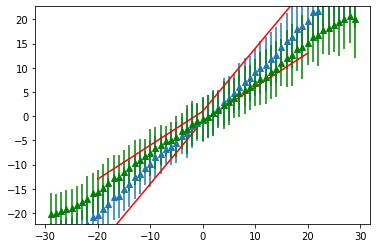

'MAE 0.6800921592166869\nMSE 0.9045477252505519\noutside 0.0\n\nopt factor 0.7666666666666666, with div_factor 1\nopt MAE 3.8516835601905655\nopt MSE 4.406929689884905\nopt outside 0.0'

In [37]:
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=epochs,  # TODO: replace with `epochs=10` here to shorten fine-tuning for tutorial if you wish
    validation_data=pipeline_val,  # here we are only using 
                                   # this data to evaluate our performance
    workers=1,
    max_queue_size=5,
    verbose=2,
    callbacks=callbacks,
)

print(f'Results on validation:')
eval_model(model, pipeline_val)

### See the results on test set
- The iterative training might result in `model` not being the *best model*, but the best of the last epoch
- This needs to be investigated, or graphs during training removed

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


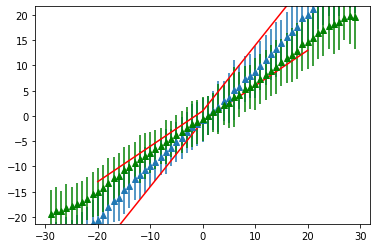

'MAE 0.6250984220434044\nMSE 0.8358510041896645\noutside 0.0\n\nopt factor 0.7333333333333332, with div_factor 1\nopt MAE 4.2601645854822685\nopt MSE 4.882512304793604\nopt outside 0.0'

In [41]:
eval_model(model, pipeline_test)

### Store model

In [39]:
model.save(model_folder / f"model_{major_version}.{minor_version}")

INFO:tensorflow:Assets written to: ../../data/models/model_6.2/assets


INFO:tensorflow:Assets written to: ../../data/models/model_6.2/assets


In [40]:
model = tf.keras.models.load_model(model_folder / f"model_{major_version}.{minor_version}")

# Evaluate scaling

In [ ]:
results = []

for i in [j for j in range(12, 13) if j not in [1, 7, 9]]:
    exclude_series = [j for j in range(i + 1, 13) if j not in [1, 7, 9]]
    trained_series = [j for j in range(1, i + 1) if j not in [1, 7, 9] and j not in exclude_series]
    
    create_dataset(data_dir, csv, [7, 9], exclude_series)
    
    ds_train = get_raw_dataset(data_dir / 'train')
    ds_val = get_raw_dataset(data_dir / 'valid')
    ds_test = get_raw_dataset(data_dir / 'test')
    
    pipeline_train = (ds_train
                  .shuffle(10000)
                  .repeat(int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH) + 1 + 50)  # repeat dataset_size / num_steps
                  .map(preprocess_train, num_parallel_calls=16)
                  .batch(BATCH_SIZE)
#                   .map(mixup, num_parallel_calls=8)
                  .map(cast_to_tuple)  # for keras model.fit
                  .prefetch(2))

    pipeline_val = (ds_val.map(preprocess_test, num_parallel_calls=16)
                      .batch(BATCH_SIZE)
                      .map(cast_to_tuple)  # for keras model.fit
#                       .cache()
                      .prefetch(2))

    pipeline_test = (ds_test.map(preprocess_test, num_parallel_calls=16)
                      .batch(BATCH_SIZE)
                      .map(cast_to_tuple)  # for keras model.fit
#                       .cache()
                      .prefetch(2))
    
    model.fit(
        pipeline_train,
        batch_size=BATCH_SIZE,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=5+10*len(trained_series),  # TODO: replace with `epochs=10` here to shorten fine-tuning for tutorial if you wish
        validation_data=pipeline_val,  # here we are only using 
                                       # this data to evaluate our performance
        workers=1,
        max_queue_size=10,
        verbose=2,
        initial_epoch=0,
        callbacks=callbacks,
    )
    
    print(f'Results on test trained on series {trained_series}:')
    mae = eval_model(model, pipeline_test)
    results.append((len(trained_series), mae))

In [ ]:
results = [
    ([2], 8.44499319732189, 9.371550683755338),
    ([2, 3], 13.37575995853969, 15.029149723215783),
    ([2, 3, 4], 7.454638554879596, 8.954571078264255),
    ([2, 3, 4, 5], 8.240593127863747, 9.514434196136829),
    ([2, 3, 4, 5, 6], 5.521295046550888, 6.479377072750131),
    ([2, 3, 4, 5, 6, 8], 2.5415429869719914, 3.2072022896644303),
    ([2, 3, 4, 5, 6, 8, 10], 1.823140286888395, 2.1770566876465356),
    ([2, 3, 4, 5, 6, 8, 10, 11], 1.8589743707009725, 2.2091262306984163)
]

In [ ]:
print(results)

In [ ]:
plt.plot([len(x[0]) for x in results], [x[1] for x in results], color='red')
plt.yscale("log")
plt.xscale("log")
plt.show()

In [ ]:
x = [np.log2(len(z[0])) for z in results]
y = [np.log2(z[1]) for z in results]

a, b = np.polyfit(x, y, 1)

plt.plot([len(x[0]) for x in results], [x[1] for x in results], color='red', linestyle='None', marker='^')

x = np.asarray((1, 25))
y = x ** a * np.exp2(b)
plt.plot(x, y, color='blue')

x_1 = (1 / np.exp2(b)) ** (1 / a)
print(x_1)
plt.plot([x_1], [1], color='blue', linestyle='None', marker='^')

plt.xticks([1, 2, 3, 4, 5, 10, 20])
plt.yscale("log")
plt.xscale("log")
plt.show()

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.ticker

fig1, ax1 = plt.subplots()

ax1.plot([len(x[0]) for x in results], [x[1] for x in results], color='red', linestyle='None', marker='^')
ax1.plot(x, y, color='blue')
ax1.plot([x_1], [1], color='blue', linestyle='None', marker='^')

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 23])
ax1.set_yticks([1, 1.8, 2.5, 5.5, 8, 13])
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.show()

# Hyper search
The pipeline (= preprocessing, since it is tf.data) can be put inside the build_model function => we can search for MixUp alpha, batch_size, etc.
- There might be a problem with RAM overflow. Try `import gc; gc.collect()`.

In [ ]:
!pip install keras_tuner

In [ ]:
import kerastuner as kt

def bit_tuning_model(module):
    def build_model(hp: kt.HyperParameters):
        input_ = tf.keras.layers.Input((CROP_TO, CROP_TO, 3))
        x = module(input_)   # Outputs feature vectors [None, 2048]
        
#         activation = hp.Choice(f'dense_activation', ['elu', 'relu'])
#         kernel_initializer = hp.Choice(f'kernel_initializer', 
#                                        ['glorot_normal', 'glorot_uniform',
#                                         'lecun_normal', 'lecun_uniform', ])
#         output_initializer = hp.Choice(f'kernel_initializer', 
#                                        ['glorot_normal', 'glorot_uniform',
#                                         'lecun_normal', 'lecun_uniform', ])
        
        for i in range(hp.Int('dense_repetition', 0, 4)):
            x = tf.keras.layers.Dropout(hp.Float(f'dropout_{i}', 0.0, 0.6))(x)
            x = tf.keras.layers.Dense(hp.Int(f'dense_units_{i}', int(2**(4-i)), int(16 * 2**(5-i)), sampling='log'),
                                      activation='relu',
                                      kernel_initializer='lecun_uniform')(x)
        x = tf.keras.layers.Dense(1, kernel_initializer='lecun_uniform')(x)

        model_ = tf.keras.Model(input_, x)
        
        callbacks = [
            tf.keras.callbacks.TensorBoard(profile_batch=0,),
            tf.keras.callbacks.EarlyStopping(patience=10),
        ]
        
        optimizer_name = hp.Choice(f'optimizer_name', ['ranger'])
        initial_lr = hp.Choice('initial_lr', [3e-2, 1.5e-2, 8e-3, 5e-3, 3e-3])
        
        if optimizer_name == 'sgd':
            lr = initial_lr * BATCH_SIZE / 512 
            # Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
            lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                               values=[lr, lr*0.1, lr*0.001, lr*0.0001])
            optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)
            
        if optimizer_name == 'adam':
            optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
            
        if optimizer_name == 'ranger':
            # add flat cos anealing from https://github.com/ronaldluc/DeepSaber/blob/52059b627a343ffacbb6f2711337569079b29916/src/train/learning_rate_schedule.py#L10
            optimizer = tfa.optimizers.RectifiedAdam(learning_rate=initial_lr,   
                                        beta_1=0.95,
                                        beta_2=0.99,
                                        epsilon=1e-6)
            optimizer = tfa.optimizers.Lookahead(optimizer)
            
        loss_name = hp.Choice(f'loss_name', ['MAE'])
        
        loss_fn = {
            'MAE': tf.keras.losses.MAE,
            'MSE': tf.keras.losses.MSE,
            'MAPE': tf.keras.losses.MeanAbsolutePercentageError,
        }[loss_name]

        model_.compile(optimizer=optimizer,
                      loss=loss_fn,
                      metrics=['mae', 'mse'])
        
        return model_
    return build_model

In [ ]:
tuner = kt.Hyperband(
    bit_tuning_model(bit_model),
    objective=kt.Objective('val_mse', direction='min'),
    hyperband_iterations=1,
    max_epochs=200,
    factor=4,
    directory=root_dir / 'hyper_search',
    project_name=f'bit_2',   # will continue in this folder => each run needs a new name
    overwrite=False,  # CAUTION!
)
tuner.search_space_summary()

callbacks = callbacks = [
    tf.keras.callbacks.TensorBoard(profile_batch=0,),
    tf.keras.callbacks.EarlyStopping(patience=10),
]

tuner.search(
        pipeline_train,
        batch_size=BATCH_SIZE,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=200,  # TODO: replace with `epochs=10` here to shorten fine-tuning for tutorial if you wish
        validation_data=pipeline_val,  # here we are only using 
                                       # this data to evaluate our performance
        workers=1,
        max_queue_size=10,
        verbose=2,
        callbacks=callbacks,
)

print(tuner.results_summary())
print(tuner.get_best_models(2)[0].summary())
print(tuner.get_best_models(2)[0].evaluate(pipeline_test))

eval_model(tuner.get_best_models(2)[0], pipeline_test)